In [1]:
import numpy as np
import itk
from itk import RTK as rtk
from FanbeamDccWithBackprojectionPlane import LinesMomentCorner
from GeneralFunctions import RecupParam, ExtractSlice
from FanbeamDccOnPhysicalDetector import ComputePlaneEquation, ExtractSourcePosition, ComputeDetectorsPosition, ComputeCylindersIntersection, ComputeNewFrame, ComputeAllDetectorPlanesIntersections, ChangeOfFrameForAll, ComputeNewFrameAndMPoints, ComputeMomentsOnCylindricalDetectors, ComputeMomentsOnCylindricalDetectorsWithSingularity, TestForSingularity, ComputeMomentsOnFlatDetectors, TrapIntegration
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


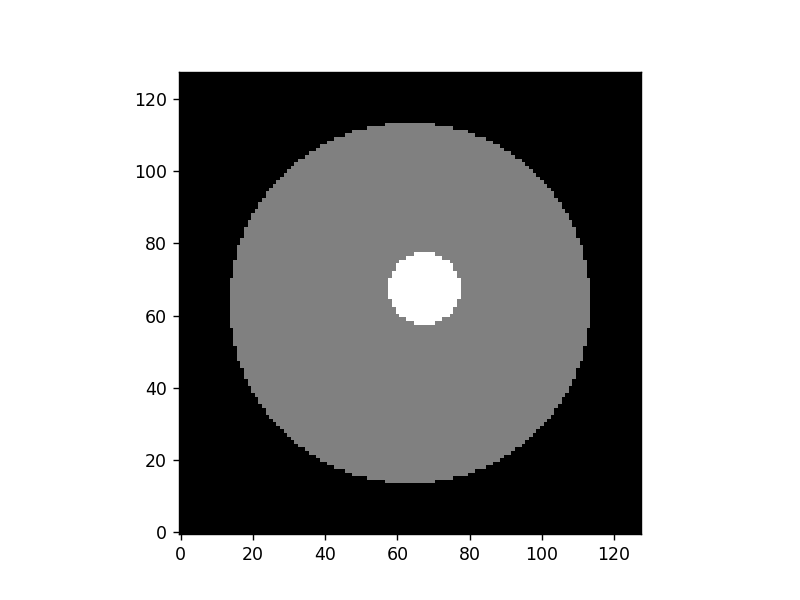

In [2]:
# Phantom computation
# We consider a simple cylinder
# Create a temporary text file for the phantom information
f = open("cylinder.txt","w")
f.write("Phantom\n")
f.write("{ [ Cylinder_y: x=0 y=0 z=0 l=200 r=50 ] rho=1. }\n")
f.write("{ [ Cylinder_y: x=4 y=0 z=4 l=200 r=10 ] rho=2. }\n")
f.close()

# Define the image type, we will use 3D float images in these hands-on sessions
ImageType = itk.Image[itk.F,3]

# Create an image filled with 0 in which we will draw the phantom
srcdraw = rtk.ConstantImageSource[ImageType].New()
srcdraw.SetSize([128,128,128])
srcdraw.SetSpacing([1]*3)
srcdraw.SetOrigin([-63.5,-63.5,-63.5])

cyldraw = rtk.DrawGeometricPhantomImageFilter[ImageType, ImageType].New()
cyldraw.SetInput(srcdraw.GetOutput())
cyldraw.SetConfigFile("cylinder.txt")
cyldraw.IsForbildConfigFileOn()
cyldraw.InPlaceOff()
cyldraw.Update()
reference = itk.GetArrayFromImage(cyldraw.GetOutput())

plt.figure()
plt.imshow(reference[:,64,:],cmap='gray',origin='lower')
plt.show()

In [3]:
# Geometry of the acquisition
# choose helical or circular trajectory
d = 0.85*16*1.2  # helical
#d = 0  # circular

# Parameters (mm)
sid = 595.0
sdd = 1085.6
sx = 0.
dx = 0.
oa = 0.
ia = 0.

# chose two angles and defined de correspondings axial positions of source and detector center
ga = np.array([0.,17.])*np.pi/180  # angles in degrees in the array
sy = d*ga/(2*np.pi)
dy = np.copy(sy)
print(ga,sy)

geometry = rtk.ThreeDCircularProjectionGeometry.New()
geometry.SetRadiusCylindricalDetector(sdd)
for i in range(ga.shape[0]):
    geometry.AddProjectionInRadians(sid,sdd,ga[i],0.,dy[i],0.,0.,0.,sy[i])

[0.         0.29670597] [0.         0.77066667]


<IPython.core.display.Javascript object>


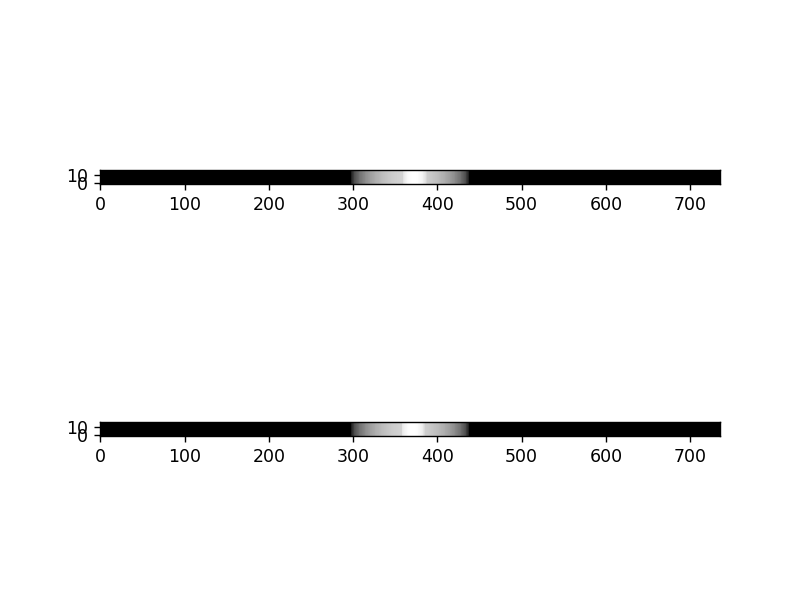

In [4]:
# Do the projections
projsize = [736,16,2]
projspacing =[1.3,1.2,1.] 
projorigin = -0.5*(np.array(projsize)-1)*np.array(projspacing)

srcproj=rtk.ConstantImageSource[ImageType].New()
srcproj.SetSize(projsize)
srcproj.SetSpacing(projspacing)
srcproj.SetOrigin(projorigin)

cylproj = rtk.ProjectGeometricPhantomImageFilter[ImageType, ImageType].New()
cylproj.SetInput(srcproj.GetOutput())
cylproj.SetConfigFile("cylinder.txt")
cylproj.SetGeometry(geometry)
cylproj.IsForbildConfigFileOn()
cylproj.Update()
proj = cylproj.GetOutput()
# itk.imwrite(cylproj.GetOutput(),'proj.mha')
sinogram = itk.GetArrayFromImage(cylproj.GetOutput())

plt.figure()
plt.subplot(211)
plt.imshow(sinogram[0,:,:],cmap='gray',origin='lower')
plt.subplot(212)
plt.imshow(sinogram[1,:,:],cmap='gray',origin='lower')
plt.show()

595.0 1085.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1085.6
595.0 1085.6 0.29670597283903605 0.0 0.7706666666666668 0.0 0.0 0.0 0.7706666666666668 1085.6


<IPython.core.display.Javascript object>


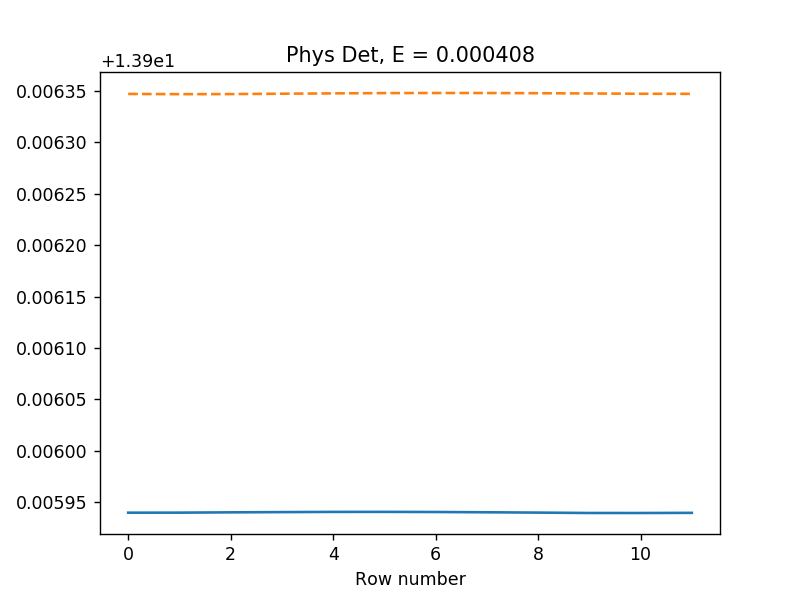

In [5]:
p0 = ExtractSlice(proj,0)
p1 = ExtractSlice(proj,1)
g0 = rtk.ThreeDCircularProjectionGeometry.New()
sid,sdd,ga0,dx0,dy0,oa,ia,sx0,sy0,R = RecupParam(geometry,0)
print(sid,sdd,ga0,dx0,dy0,oa,ia,sx0,sy0,R)
# print('a0 = %f °' %(ga0*180/np.pi))
g0.SetRadiusCylindricalDetector(R)
g0.AddProjectionInRadians(sid,sdd,ga0,dx0,dy0,oa,ia,sx0,sy0)
g1 = rtk.ThreeDCircularProjectionGeometry.New()
sid,sdd,ga1,dx,dy,oa,ia,sx,sy,R = RecupParam(geometry,1)
print(sid,sdd,ga1,dx,dy,oa,ia,sx,sy,R)
# print('a1 = %f °' %(ga1*180/np.pi))
g1.SetRadiusCylindricalDetector(R)
g1.AddProjectionInRadians(sid,sdd,ga1,dx,dy,oa,ia,sx,sy)

# # Compute moments with backprojection plane
# m0 = LinesMomentCorner(g0,g1,p0)
# m1 = LinesMomentCorner(g1,g0,p1)

# # Compute moments on the physical detectors
if R == 0:
    m0bis, m1bis = ComputeMomentsOnFlatDetectors(g0,g1,p0,p1)
else:
    m0bis, m1bis, sing0, sing1, rest0, rest1 = ComputeMomentsOnCylindricalDetectorsWithSingularity(g0,g1,p0,p1)

plt.figure()
# plt.subplot(121)
# plt.plot(m0)
# plt.plot(m1,'--')
# plt.ylabel('Moments (u.a.)')
# plt.xlabel('Row number')
# plt.title("Virt Det, E = %f" %(np.sqrt(np.sum((m0-m1)**2)/len(m0))))
# plt.subplots_adjust(wspace = 0.4)
# plt.subplot(122)
plt.title("Phys Det, E = %f" %(np.sqrt(np.sum((m0bis-m1bis)**2)/len(m0bis))))
plt.plot(m0bis)
plt.plot(m1bis,'--')
plt.xlabel('Row number')
plt.show()

# print("Central plane values")
# print(m0[m0.shape[0]//2], m1[m1.shape[0]//2], m0bis[m0bis.shape[0]//2], m1bis[m1bis.shape[0]//2])


<IPython.core.display.Javascript object>


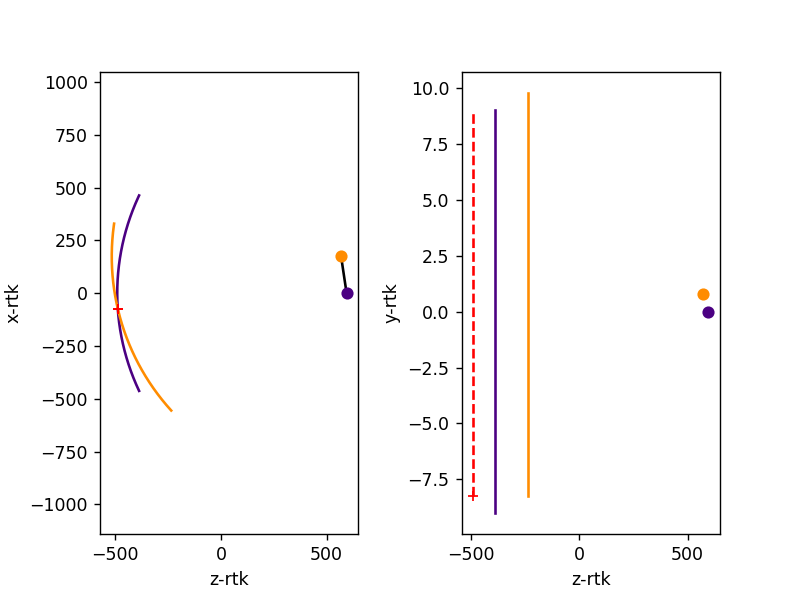

In [6]:
# Geometrical illustration of the pair, M points and new frame
sourcePos0, sourcePos1 = ExtractSourcePosition(g0, g1)
D = g0.GetSourceToDetectorDistances()[0]
R = g0.GetSourceToIsocenterDistances()[0]
Det0, Det1, gamma_RTK = ComputeDetectorsPosition(g0, g1, p0, p1)
PMs = ComputeNewFrameAndMPoints(p0.GetLargestPossibleRegion().GetSize()[0], p0.GetSpacing()[1], Det0, Det1, g0, g1)

plt.figure()
plt.subplot(1,2,1)
plt.plot([sourcePos0[2],sourcePos1[2]],[sourcePos0[0],sourcePos1[0]],'k')
plt.plot(sourcePos0[2],sourcePos0[0],'.',markersize = 12 ,color = 'indigo')
plt.plot(sourcePos1[2],sourcePos1[0],'.',markersize = 12 ,color = 'darkorange')
plt.plot(Det0[:,0,2],Det0[:,0,0],color = 'indigo' )
plt.plot(Det1[:,0,2],Det1[:,0,0],color = 'darkorange' )
plt.plot([PMs[2][:]],[PMs[0][:]],'r+')
plt.axis('equal')
plt.xlabel('z-rtk')
plt.ylabel('x-rtk')
plt.subplots_adjust(wspace = 0.4)
plt.subplot(1,2,2)
plt.plot(sourcePos0[2],sourcePos0[1],'.',markersize = 12 ,color = 'indigo')
plt.plot(sourcePos1[2],sourcePos1[1],'.',markersize = 12 ,color = 'darkorange')
plt.plot(Det0[0,:,2],Det0[0,:,1],color = 'indigo' )
plt.plot(Det1[0,:,2],Det1[0,:,1],color = 'darkorange' )
plt.plot(PMs[2][:],PMs[1][:],'r--')
# plt.plot([PMs[2][PMs.shape[1]//2]],[PMs[1][PMs.shape[1]//2]],'r+')
plt.plot([PMs[2][0]],[PMs[1][0]],'r+')
# plt.plot([sourcePos0[2],sourcePos1[2]],[sourcePos0[1],sourcePos1[1]],'k')
# plt.plot([sourcePos0[2],PMs[2][row]],[sourcePos0[1],PMs[1][row]],'k')
# plt.plot([sourcePos1[2],PMs[2][row]],[sourcePos1[1],PMs[1][row]],'k')
# plt.axis('equal')
plt.xlabel('z-rtk')
plt.ylabel('y-rtk')
plt.show()

<IPython.core.display.Javascript object>


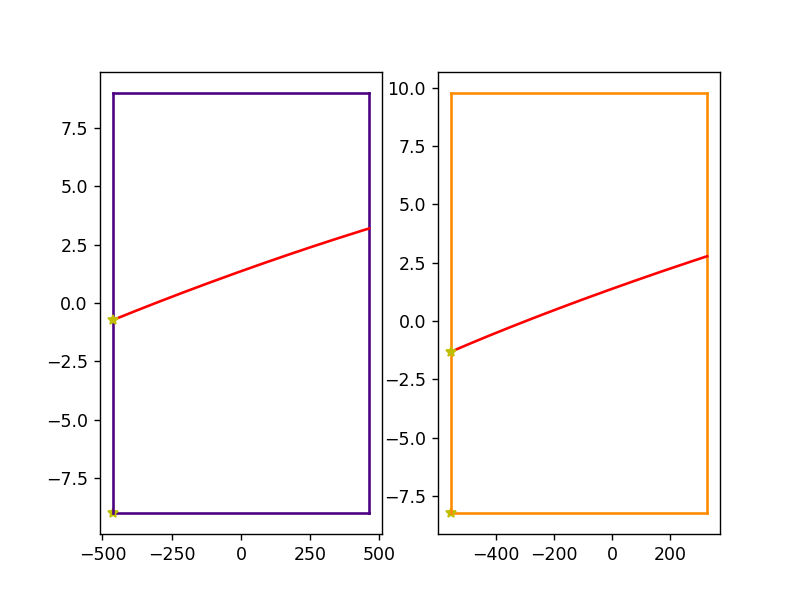

In [7]:
# Show intersection curve between central plane and the detectors before the change of frame
x1, z1, Inter1, x0, z0, Inter0, M_ACC, ze = ComputeAllDetectorPlanesIntersections(g0, g1, Det0, Det1, PMs, p0.GetSpacing()[1])

# print(ze)

row = M_ACC.shape[0]//2

plt.figure()
plt.subplot(121)
plt.plot(Det0[:,0,0],Det0[:,0,1],color = 'indigo')
plt.plot(Det0[0,0,0],Det0[0,0,1],'y*')
plt.plot(Det0[:,-1,0],Det0[:,-1,1],color = 'indigo')
plt.plot(Det0[0,:,0],Det0[0,:,1],color = 'indigo')
plt.plot(Det0[-1,:,0],Det0[-1,:,1],color = 'indigo')
plt.plot(x0,Inter0[row],color = 'red')
plt.plot([x0[0]],[Inter0[row][0]],'y*')
plt.subplot(122)
plt.plot(Det1[:,0,0],Det1[:,0,1],color = 'darkorange')
plt.plot(Det1[0,0,0],Det1[0,0,1],'y*')
plt.plot(Det1[:,-1,0],Det1[:,-1,1],color = 'darkorange')
plt.plot(Det1[0,:,0],Det1[0,:,1],color = 'darkorange')
plt.plot(Det1[-1,:,0],Det1[-1,:,1],color = 'darkorange')
plt.plot(x1,Inter1[row],color = 'red')
plt.plot([x1[0]],[Inter1[row][0]],'y*')
plt.show()

<IPython.core.display.Javascript object>


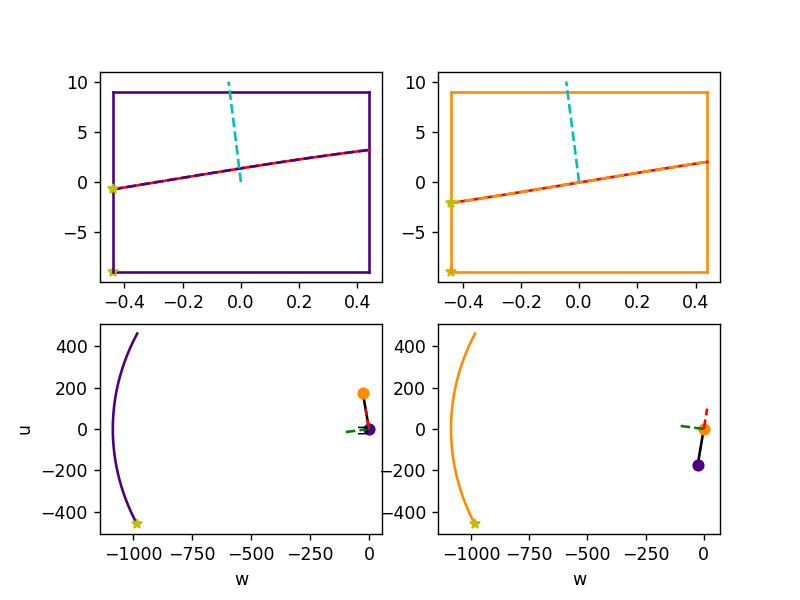

In [8]:
# Change of frame for all the previous computations
xe = sourcePos0[0:3] - sourcePos1[0:3]
xe /= np.linalg.norm(xe)
if (np.dot(xe, np.array([1., 0., 0.])) < 0):
          xe *= -1

# Change of frame for all the previous computations
Interbis0, center0, s1bis, DETbis0, PMs0, ze0, xe0 = ChangeOfFrameForAll(ga0, sourcePos0, sourcePos0, sourcePos1, Det0, x0, z0, Inter0, D, M_ACC,xe)
Interbis1, s0bis, center1, DETbis1, PMs1, ze1, xe1 = ChangeOfFrameForAll(ga1, sourcePos1, sourcePos0, sourcePos1, Det1, x1, z1, Inter1, D, M_ACC,xe)
ye0 = np.cross(ze0,xe0)
ye1 = np.cross(ze1,xe1)

plt.figure()
plt.subplot(221)
plt.plot(gamma_RTK,DETbis0[:,0,1],color = 'indigo')
plt.plot(gamma_RTK[0],DETbis0[0,0,1],'y*')
plt.plot(gamma_RTK,DETbis0[:,-1,1],color = 'indigo')
plt.plot(gamma_RTK[0]*np.ones(DETbis0.shape[1]),DETbis0[0,:,1],color = 'indigo')
plt.plot(gamma_RTK[-1]*np.ones(DETbis0.shape[1]),DETbis0[-1,:,1],color = 'indigo')
plt.plot(gamma_RTK,Interbis0[:,row,1],color = 'red')
plt.plot(gamma_RTK,D*(-np.sin(gamma_RTK)*ze0[row,0]+np.cos(gamma_RTK)*ze0[row,2])/ze0[row,1],'--',color = 'indigo')
plt.plot(gamma_RTK[0],D*(-np.sin(gamma_RTK[0])*ze0[row,0]+np.cos(gamma_RTK[0])*ze0[row,2])/ze0[row,1],'y*')
plt.plot([0,10*ze0[row,0]],[0,10*ze0[row,1]],'c--')
plt.subplot(222)
plt.plot(gamma_RTK,DETbis1[:,0,1],color = 'darkorange')
plt.plot(gamma_RTK[0],DETbis1[0,0,1],'y*')
plt.plot(gamma_RTK,DETbis1[:,-1,1],color = 'darkorange')
plt.plot(gamma_RTK[0]*np.ones(DETbis1.shape[1]),DETbis1[0,:,1],color = 'darkorange')
plt.plot(gamma_RTK[-1]*np.ones(DETbis1.shape[1]),DETbis1[-1,:,1],color = 'darkorange')
plt.plot(gamma_RTK,Interbis1[:,row,1],color = 'red')
plt.plot(gamma_RTK,D*(-np.sin(gamma_RTK)*ze1[row,0]+np.cos(gamma_RTK)*ze1[row,2])/ze1[row,1],'--',color = 'darkorange')
plt.plot(gamma_RTK[0],D*(-np.sin(gamma_RTK[0])*ze1[row,0]+np.cos(gamma_RTK[0])*ze1[row,2])/ze1[row,1],'y*')
plt.plot([0,10*ze1[row,0]],[0,10*ze1[row,1]],'c--')
plt.subplot(223)
plt.plot([center0[2],s1bis[2]],[center0[0],s1bis[0]],'k')
plt.plot(center0[2],center0[0],'.',markersize = 12 ,color = 'indigo')
plt.plot(s1bis[2],s1bis[0],'.',markersize = 12 ,color = 'darkorange')
plt.plot(DETbis0[:,0,2],DETbis0[:,0,0],color = 'indigo' )
plt.plot(DETbis0[0,0,2],DETbis0[0,0,0],'y*' )
# plt.plot(-D*np.cos(gamma_RTK),D*np.sin(gamma_RTK),'--')
plt.plot([0,100*xe0[2]],[0,100*xe0[0]],'r--')
plt.plot([0,100*ye0[row,2]],[0,100*ye0[row,0]],'g--')
plt.xlabel('w')
plt.ylabel('u')
plt.subplot(224)
plt.plot([center1[2],s0bis[2]],[center1[0],s0bis[0]],'k')
plt.plot(center1[2],center1[0],'.',markersize = 12 ,color = 'darkorange')
plt.plot(s0bis[2],s0bis[0],'.',markersize = 12 ,color = 'indigo')
plt.plot(DETbis1[:,0,2],DETbis1[:,0,0],color = 'darkorange' )
plt.plot(DETbis1[0,0,2],DETbis1[0,0,0], 'y*' )
# plt.plot(-D*np.cos(gamma_RTK),D*np.sin(gamma_RTK),'--')
plt.plot([0,100*xe1[2]],[0,100*xe1[0]],'r--')
plt.plot([0,100*ye1[row,2]],[0,100*ye1[row,0]],'g--')
plt.xlabel('w')
plt.ylabel('u')
plt.show()